In [1]:
%matplotlib inline

# NLP: RNN Name Classification

This tutorial is adapted from [the PyTorch Tutorials](https://pytorch.org/tutorials/) and [Sean Robertson](https://github.com/spro), valuable references for learning the fundamentals of Natural Language Processing in PyTorch. We highly recommend exploring other tutorials for deeper understanding and additional topics.

In this tutorial we'll guide you through building and training your own RNN, starting from scratch. We'll break down the process into bite-sized steps, focusing on the essential building blocks of NLP from data preprocessing to training and evaluation. By crafting each component yourself, you'll gain a deep understanding of how RNNs handle text data and make confident predictions on words. 

You'll learn to employ a character-level recurrent neural network (RNN) for the purpose of classifying surnames based on their spelling. The RNN processes each word character by character, generating a prediction and updating its internal hidden state at each step. The final prediction, representing the most likely class (i.e., language of origin), is derived from the final hidden state.

Specifically, we'll train the RNN on a dataset of several thousand surnames spanning 18 distinct languages. This approach holds promise for exploring the relationship between orthography and linguistic ancestry, potentially yielding insights into language evolution and migration patterns:

::

    predict('Hinton')
    > Hinton
    (-0.47) Scottish
    (-1.52) English
    (-3.57) Irish

    predict('Schmidhuber')
    > Schmidhuber
    (-0.19) German
    (-2.48) Czech
    (-2.68) Dutch

## Preparing the Data

The dataset resides within the ``data/names`` directory and comprises 18 text files, each named according to the language it represents (e.g., ``[English].txt``). Each file contains a collection of surnames, presented one name per line. While most names are already in Romanized format, a preprocessing step to convert them from Unicode to ASCII is necessary for compatibility with subsequent modeling phases.

The preprocessing phase culminates in the construction of a structured dictionary, designed to facilitate model training and analysis. This dictionary adopts the format ``{language: [names ...]}``, effectively associating each language with its corresponding list of surnames. The use of generic variable names, such as ``category`` and ``line``, promotes code reusability and adaptability for future endeavors involving different data types and categories. 

In [2]:
# Import libraries for file handling, text processing, and character operations

# `io` module for efficient file I/O operations
from io import open

# `glob` module for finding files based on patterns
import glob

# `os` module for interacting with the operating system and file paths
import os

# `unicodedata` module for working with Unicode characters and normalization
import unicodedata

# `string` module for string constants and methods, including punctuation and whitespace
import string

In [3]:
# Define a function to find files matching a pattern in a given directory
def find_files(path: str) -> list[str]:
    """
    Efficiently finds files matching a pattern within a specified directory.

    Args:
        path (str): The directory path to search, including a wildcard pattern for file names.

    Returns:
        list[str]: A list of full file paths that match the pattern.
    """

    return glob.glob(path) # Use the glob.glob function to perform the file search

# Example usage:
text_files = find_files("data/names/*.txt")  # Find text files in the 'data/names' directory
print(text_files)

['data/names/Czech.txt', 'data/names/German.txt', 'data/names/Arabic.txt', 'data/names/Japanese.txt', 'data/names/Chinese.txt', 'data/names/Vietnamese.txt', 'data/names/Russian.txt', 'data/names/French.txt', 'data/names/Irish.txt', 'data/names/English.txt', 'data/names/Spanish.txt', 'data/names/Greek.txt', 'data/names/Italian.txt', 'data/names/Portuguese.txt', 'data/names/Scottish.txt', 'data/names/Dutch.txt', 'data/names/Korean.txt', 'data/names/Polish.txt']


In [4]:
# Define the set of allowed characters for ASCII conversion
allowed_chars = string.ascii_letters + " .,;'"  # Includes letters, spaces, and common punctuation
n_letters = len(allowed_chars)  # Calculate the total number of allowed characters

In [5]:
# Define a function to convert Unicode strings to plain ASCII
# Thanks to https://stackoverflow.com/a/518232/2809427
def ascii_sanitize(text, allowed_chars=allowed_chars):
   """Converts a Unicode string to plain ASCII, removing diacritics and filtering non-allowed characters.

   Args:
       text (str): The Unicode string to convert.
       allowed_chars (str): A string containing allowed characters.

   Returns:
       str: The ASCII-converted string.
   """

   normalized = unicodedata.normalize('NFD', text)  # Decompose characters
   return ''.join(
       c for c in normalized
       if unicodedata.category(c) != 'Mn'  # Exclude combining diacritics
       and c in allowed_chars  # Keep only allowed characters
   )

# Example usage: Convert a string with diacritics to ASCII
print(ascii_sanitize('Ślusàrski', allowed_chars))  # Output: Slusarski

Slusarski


In [6]:
# Initialize data structures for organizing names by language
category_lines = {}  # Dictionary to store lists of names for each language
all_categories = []  # List to keep track of all unique languages encountered

In [7]:
# Define a function to read a file and convert its lines to ASCII
def read_lines(filename: str) -> list[str]:
    """Reads a file, converts its lines to ASCII, and returns the converted lines.

    Args:
        filename (str): The path to the file to read.

    Returns:
        list[str]: A list of ASCII-converted lines from the file.
    """

    with open(filename, encoding='utf-8') as file:  # Open the file with UTF-8 encoding for proper character handling
        return [ascii_sanitize(line.strip(), allowed_chars) for line in file]  # Process each line efficiently:
                                                           #   - line.strip(): Remove leading/trailing whitespace
                                                           #   - ascii_sanitize(): Convert to ASCII using allowed characters
                                                           #   - List comprehension: Efficiently create a list of converted lines

In [8]:
# Process each text file in the 'data/names' directory
for filename in find_files("data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0] # Extract the language category from the file name
    all_categories.append(category)  # Add category only once outside the loop
    category_lines[category] = read_lines(filename) # Store the lines in the dictionary under the corresponding category

# Count the total number of unique language categories
n_categories = len(set(all_categories))  # Use a set for unique categories
print(f"Number of unique categories: {n_categories}") # Print the number of categories

# Access and print a sample of names from the 'Italian' category
print("Sample of Italian names:")
print(category_lines["Italian"][:5]) # Retrieve the first 5 names from the 'Italian' list in the dictionary

Number of unique categories: 18
Sample of Italian names:
['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


**Data Structure Recap:**

* ``category_lines``: This dictionary forms the primary data structure, mapping each language category (key) to a list of corresponding names (value). Essentially, it provides a language-indexed organization of all surnames.
* ``all_categories``: This auxiliary list maintains a record of all unique language categories encountered in the dataset. While not directly involved in model training, it can be helpful for tracking available languages and performing additional analyses.
* ``n_categories``: This integer variable stores the total number of distinct language categories present in the dataset. It provides convenient access to the overall language diversity and can be used in calculations or reporting.

### Tensor Representation for Character-Level Modeling:

To facilitate model training, we transform the textual data into numerical tensors, a format compatible with PyTorch's computational framework. This process involves two key steps:

1. **One-Hot Encoding of Letters:**
   - Each individual letter is represented by a one-hot vector, a sparse vector of size ``<1 x n_letters>`` containing zeros in all positions except for a single one at the index corresponding to the letter's position in the alphabet, e.g. ``"b" = <0 1 0 0 0 ...>``. This encoding effectively captures the discrete nature of letters within a word.

2. **Word Matrix Construction:**
   - To represent an entire word, we concatenate the one-hot vectors of its constituent letters, forming a 2D matrix with dimensions ``<line_length x 1 x n_letters>``.
   - The additional dimension of size 1 is introduced to align with PyTorch's batch processing paradigm, even though we're working with individual words in this context.

By employing this tensor-based representation, we enable the model to leverage the rich information embedded within the characters for language classification tasks.

In [9]:
# Import the PyTorch library for deep learning operations
import torch

In [10]:
# Define a function to map a letter to its index in the allowed_chars list
# e.g. "a" = 0
def letter_to_index(letter: str) -> int:
    """Efficiently finds the index of a letter within the allowed_chars list.

    Args:
        letter (str): The letter to search for.

    Returns:
        int: The index of the letter, or -1 if not found.
    """

    return allowed_chars.index(letter)  # Use index() for clarity and potential performance benefits

In [11]:
# Define a function to create a one-hot tensor for a single letter
# e.g. <1 x n_letters> Tensor
def letter_to_tensor(letter: str) -> torch.Tensor:
    """Efficiently creates a one-hot tensor representation for a given letter.

    Args:
        letter (str): The letter to convert.

    Returns:
        torch.Tensor: A 1D tensor of shape (1, n_letters) with a 1 at the letter's index.
    """

    tensor = torch.zeros(1, n_letters)      # Create a zero tensor of size (1, n_letters)
    tensor[0, letter_to_index(letter)] = 1  # Use direct indexing for clarity
    return tensor

In [12]:
# Define a function to create a tensor for a whole line (word)
# e.g. <line_length x 1 x n_letters>
def line_to_tensor(line: str) -> torch.Tensor:
    """Efficiently creates a 2D tensor representation for a line (word).

    Args:
        line (str): The line to convert.

    Returns:
        torch.Tensor: A 2D tensor of shape (line_length, 1, n_letters) representing the word.
    """

    return torch.stack([letter_to_tensor(letter) for letter in line])  # Concisely create the tensor using torch.stack

In [13]:
# Example usage:
print(f"One-hot tensor for 'J':\n{letter_to_tensor('J')}")  # Formatted output
print(f"Size of tensor for 'Jones': {line_to_tensor('Jones').size()}")

One-hot tensor for 'J':
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
Size of tensor for 'Jones': torch.Size([5, 1, 57])


## Creating the Network

**Streamlined RNN Implementation Leveraging Autograd:**

In prior versions of Torch, constructing recurrent neural networks (RNNs) hinged upon manual cloning of layer parameters across multiple timesteps. However, the advent of autograd has significantly streamlined this process, enabling a more elegant and efficient approach. By gracefully handling hidden state management and gradient propagation within the computational graph itself, autograd permits the implementation of RNNs as a sequence of straightforward feed-forward layers.

**Concise RNN Architecture:**

The RNN module in this tutorial, mostly copied from [the PyTorch for Torch users tutorial](https://pytorch.org/tutorials/beginner/former_torchies/nn_tutorial.html#example-2-recurrent-net), showcases this paradigm shift. It comprises a remarkably simple architecture, consisting of:

- **Two Linear Layers:** These layers perform primary computations on both input data and hidden state, acting as the core building blocks of the RNN.
- **LogSoftmax Layer:** Situated at the output, this layer transforms raw output scores into probabilities for each class, facilitating prediction and interpretation.

This refined model demonstrates the power of autograd to simplify RNN design and implementation, fostering a clear and concise approach to character-level modeling.

In [14]:
# Import the neural network module from PyTorch for building and managing neural network layers
import torch.nn as nn

In [15]:
# Define the RNN Class:
class RNN(nn.Module):  # Create a custom RNN class inheriting from nn.Module
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()  # Call the parent class constructor

        self.hidden_size = hidden_size  # Store the hidden layer size

        # Define the model layers:
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # Input-to-hidden layer
        self.h2o = nn.Linear(hidden_size, output_size)  # Hidden-to-output layer
        self.softmax = nn.LogSoftmax(dim=1)  # LogSoftmax layer for output probabilities

    def forward(self, input, hidden):  # Define the forward pass of the model
        combined = torch.cat((input, hidden), 1)  # Concatenate input and hidden state
        hidden = self.i2h(combined)  # Pass concatenated input through the input-to-hidden layer
        output = self.h2o(hidden)  # Pass hidden state through the hidden-to-output layer
        output = self.softmax(output)  # Apply LogSoftmax to output for probabilities
        return output, hidden  # Return both output and updated hidden state

    def initHidden(self):  # Function to initialize hidden state
        return torch.zeros(1, self.hidden_size)  # Create a zero tensor for hidden state

# Create an RNN Instance:
n_hidden = 128  # Set the hidden layer size
rnn = RNN(n_letters, n_hidden, n_categories)  # Create an RNN instance with specified dimensions

**Executing a Single RNN Step:**

To process each letter within a word, the RNN performs the following steps:

1. **Input and Hidden State:**
   - The model accepts two inputs:
     - The tensor representation of the current letter, reflecting the character's unique identity within the word.
     - The hidden state carried over from the preceding step, initialized as a zero tensor at the starting point.

2. **Internal Calculations:**
   - Within its hidden depths, the RNN interweaves these inputs, embarking on a series of computations:
     - It joins the letter tensor and hidden state, creating a blend of information.
     - This is then passed through a succession of interconnected layers, each designed to extract and amplify the most salient features.
     - The hidden state undergoes a transformation, guided by the model's learned parameters to capture the essence of the word's progression.

3. **Output and Updated State:**
   - The RNN yields two outputs:
     - A probability distribution, crafted by the LogSoftmax layer, revealing the model's insights into the language affiliations of the word.
     - An updated hidden state, embodying the accumulated knowledge gleaned from previous letters and used to influence the interpretation of those yet to come.

4. **Recurrent Flow:**
   - This letter processing, output generation, and state preservation continues iteratively, with each step building upon the information of its predecessors, until the word's final letter signals the completion of the RNN.

In [16]:
input = letter_to_tensor('A')  # Create a one-hot tensor for the letter 'A'
hidden = torch.zeros(1, n_hidden)  # Create a zero tensor to represent the initial hidden state

output, next_hidden = rnn(input, hidden)  # Run a single step of the RNN, feeding the input and hidden state

**Optimizing Input Encoding for Enhanced Efficiency:**

To maximize computational efficiency during prediction, we avoid generating a new one-hot tensor for each individual letter within a word. Instead, we leverage the ``line_to_tensor`` function which efficiently processes the entire word as a sequence of characters. This avoids the overhead of repeated tensor creation and manipulation for each letter. Further optimization opportunities lie in the precomputation of word batches as tensors, minimizing runtime overhead through batch processing techniques.

By employing these optimization strategies, we ensure streamlined inference and accelerate the model's prediction capabilities.

In [17]:
input = line_to_tensor('Albert')  # Create a tensor representation for the entire word 'Albert'
hidden = torch.zeros(1, n_hidden)  # Create a zero tensor to represent the initial hidden state

output, next_hidden = rnn(input[0], hidden)  # Run a single step of the RNN, feeding the first letter tensor and hidden state
print(output)  # Display the output probabilities for language categories, based on the first letter

tensor([[-2.9535, -2.9068, -2.8461, -2.8693, -2.9053, -2.7971, -2.9133, -2.8861,
         -2.8666, -2.8098, -2.9473, -2.8708, -2.8259, -2.8734, -2.9011, -2.8886,
         -2.9667, -3.0267]], grad_fn=<LogSoftmaxBackward0>)


**Interpreting Model Output:**

The model's output is crafted as a tensor of dimensions ``<1 x n_categories>``, expressing its assessment of the word's language affiliations. Each element within this tensor holds a numerical value, indicating the estimated probability of the word belonging to the corresponding language category. Higher numerical values reflect greater confidence in a particular language association, while lower values suggest a more tenuous connection. By examining this array of probabilities, we gain understanding of the model's insights into the linguistic origins of the word.

## Training
Preparing for Training
----------------------

To streamline model training and enhance code readability, we'll construct a set of helper functions. The first of these functions, ``category_from_output``, will serve as an interpreter of the model's predictions. It will extract the most likely language category from the output tensor, using the ``Tensor.topk`` method to identify the index corresponding to the highest probability.

In [18]:
def category_from_output(output: torch.Tensor) -> tuple[str, int]:
    """Efficiently determines the most likely language category from model output.

    Args:
        output (torch.Tensor): Model's output tensor of probabilities.

    Returns:
        tuple[str, int]: Predicted language category and its index.
    """

    # Find the index of the highest probability value:
    _, top_i = output.topk(1)  # Extract top index directly
    category_i = top_i.item()  # Unpack index from tensor

    # Return both the category name and index:
    return all_categories[category_i], category_i # Maps index to language category

In [19]:
# Example usage:
# Visually interpret model's prediction for language category:
predicted_category, category_index = category_from_output(output)
print(f"Predicted language category: {predicted_category} (index: {category_index})")

Predicted language category: Vietnamese (index: 5)


For training efficiency, we need a convenient method to access training examples (name-language pairs):

In [20]:
# Import the random module to introduce elements of chance and variability
import random

In [21]:
# Function to randomly select an element from a list
def random_choice(l: list) -> any:
    """Efficiently selects a random element from a list.

    Args:
        l (list): The list to choose from.

    Returns:
        Any: A random element from the list.
    """

    return random.choice(l)  # Directly use random.choice for simplicity and efficiency

In [22]:
# Function to generate a random training example
def random_training_example() -> tuple[str, str, torch.Tensor, torch.Tensor]:
    """Efficiently generates a random training example for language classification.

    Returns:
        tuple[str, str, torch.Tensor, torch.Tensor]: A tuple containing:
            - category (str): The randomly chosen language category.
            - line (str): A randomly selected name from the chosen category.
            - category_tensor (torch.Tensor): A tensor representing the category index.
            - line_tensor (torch.Tensor): A tensor representing the name as one-hot character vectors.
    """
    # Randomly selects a language category
    category = random.choice(all_categories)

    # Randomly chooses a name from the selected category
    line = random.choice(category_lines[category])

    # Creates a tensor for the category index
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long) 

    # Converts the name into a tensor of one-hot character vectors
    line_tensor = line_to_tensor(line)

    # Returns the category, name, and their tensors
    return category, line, category_tensor, line_tensor

In [23]:
# Example usage:
for _ in range(10):  # Use _ to indicate unused loop variable
    category, line, _, _ = random_training_example()  # Unpack only needed values
    print(f"Generated example: Category = {category}, Line = {line}")  # Formatted output

Generated example: Category = Italian, Line = Vitali
Generated example: Category = Vietnamese, Line = Trinh
Generated example: Category = Portuguese, Line = Silva
Generated example: Category = Russian, Line = Shakhlamov
Generated example: Category = Japanese, Line = Inukai
Generated example: Category = Japanese, Line = Akita
Generated example: Category = Chinese, Line = Chai
Generated example: Category = Korean, Line = Jeong
Generated example: Category = Spanish, Line = Gallego
Generated example: Category = Russian, Line = Belnikov


### Training the Network

**Initiating Model Training:**

- The training process involves iteratively exposing the model to diverse examples, enabling it to refine its knowledge through a feedback loop.
- The model generates predictions for each example, and any discrepancies between its estimates and the ground truth are quantified as a loss.
- To align with the model's ``nn.LogSoftmax`` output layer, we employ the ``nn.NLLLoss`` function for accurate loss calculation.

In [24]:
# Instantiate the loss function for measuring prediction errors
criterion = nn.NLLLoss()  # Negative log likelihood loss, suitable for LogSoftmax output

**The Training Loop:**

1. **Prepare Training Data:** Generate input and target tensors representing the name and its true language category.
2. **Initialize Hidden State:** Set the hidden state to zero, ready to capture information across the word.
3. **Process Letters Sequentially:** Iterate over each letter in the name:
    - Pass the current letter and hidden state through the RNN.
    - Update the hidden state to hold information for the next letter.
4. **Evaluate Prediction:** Compare the final model output with the target language category.
5. **Optimize Network:** Calculate the loss and backpropagate through the network, updating its parameters to improve future predictions.
6. **Return Performance Metrics:** Collect the output and loss values for analysis and tracking progress.

In [25]:
# Set the learning rate, a crucial hyperparameter governing model convergence
learning_rate = 0.005 # Judiciously selected to balance learning speed and stability
                      # If too high, updates might become erratic; if too low, progress might stagnate.

In [26]:
def train(category_tensor: torch.Tensor, line_tensor: torch.Tensor) -> tuple[torch.Tensor, float]:
    """Efficiently trains the RNN on a single training example.

    Args:
        category_tensor (torch.Tensor): Target category tensor.
        line_tensor (torch.Tensor): Word tensor as one-hot character vectors.

    Returns:
        tuple[torch.Tensor, float]: Model's output tensor and calculated loss.
    """

    hidden = rnn.initHidden()  # Initialize hidden state

    # Clear gradients for a fresh start
    rnn.zero_grad()  # Ensures past gradients don't influence current updates

    # Iterate over each letter in the word:
    for i in range(line_tensor.size(0)):
        output, hidden = rnn(line_tensor[i], hidden)  # Feed the current letter and hidden state to the RNN

    # Calculate loss based on prediction and target
    loss = criterion(output, category_tensor) # Quantifies prediction error using NLLLoss

    # Backpropagate to compute gradients
    loss.backward() # Calculates gradients for each parameter

    # Update model parameters using calculated gradients
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)  # Adjusts parameters to minimize loss

    # Return output and loss for monitoring
    return output, loss.item()  # Provides insights into model performance

 **Iteratively Refining Predictions:**

- The model's learning is honed through repeated exposure to a multitude of diverse training examples.
- During each training iteration, the `train` function yields both model output and loss, enabling us to closely monitor its progress.
- While training on thousands of examples, we selectively print predictions and loss values at regular intervals (defined by `print_every`) for efficient feedback and analysis.
- To depict long-term trends and mitigate the impact of potential fluctuations, we track the average loss over time, providing a more comprehensive perspective on model performance.

In [27]:
# Import the time module to measure and manage time-related events
import time

# Import the math module to access mathematical functions and constants
import math

In [28]:
# Establish training parameters
n_iters = 100000  # Set the total number of training iterations
print_every = 5000  # Frequency for printing updates and examples
plot_every = 1000  # Frequency for plotting loss values

# Initialize variables for tracking and visualizing loss
current_loss = 0  # Accumulate loss values within a print_every interval
all_losses = []  # Store loss values for analysis and plotting

In [29]:
def time_since(since: float) -> str:
    """Efficiently calculates and formats the time elapsed since a reference point.

    Args:
        since (float): The reference time in seconds.

    Returns:
        str: A formatted string representing the elapsed time in minutes and seconds.
    """

    elapsed = time.time() - since  # Calculate elapsed time in seconds
    minutes = int(elapsed // 60)  # Extract minutes
    seconds = int(elapsed % 60)  # Extract remaining seconds
    return f"{minutes:02d}:{seconds:02d}"  # Format as MM:SS

In [30]:
# Record the starting time for tracking training duration:
start_time = time.time()

# Begin the training loop:
for iteration in range(1, n_iters + 1):  # Iterate through the specified number of training cycles

    # Generate a new training example:
    category, line, category_tensor, line_tensor = random_training_example()

    # Train the model on the current example:
    output, loss = train(category_tensor, line_tensor)

    # Accumulate loss for later analysis:
    current_loss += loss

    # Periodically print progress and insights:
    if iteration % print_every == 0:
        # Decipher the model's prediction:
        guess, guess_i = category_from_output(output)

        # Indicate whether the prediction was correct:
        accuracy_indicator = '✓' if guess == category else f'✗ ({category})'

        # Print a comprehensive progress report:
        print(f"Iteration: {iteration:4d} ({iteration/n_iters*100:.2f}%)  "
              f"Time: {time_since(start_time)}  Loss: {loss:.4f}  "
              f"Name: {line}  Prediction: {guess} {accuracy_indicator}")

    # Periodically record loss values for visualization:
    if iteration % plot_every == 0:
        all_losses.append(current_loss / plot_every)  # Append the average loss over the interval
        current_loss = 0  # Reset for the next interval

Iteration: 5000 (5.00%)  Time: 00:01  Loss: 2.7263  Name: Hammond  Prediction: Italian ✗ (English)
Iteration: 10000 (10.00%)  Time: 00:03  Loss: 1.8419  Name: Vela  Prediction: Spanish ✓
Iteration: 15000 (15.00%)  Time: 00:04  Loss: 5.9898  Name: Kokkali  Prediction: Japanese ✗ (Greek)
Iteration: 20000 (20.00%)  Time: 00:06  Loss: 1.5756  Name: Santos  Prediction: Greek ✗ (Portuguese)
Iteration: 25000 (25.00%)  Time: 00:07  Loss: 1.2748  Name: Delgado  Prediction: Italian ✗ (Spanish)
Iteration: 30000 (30.00%)  Time: 00:09  Loss: 3.3617  Name: Cameron  Prediction: French ✗ (Scottish)
Iteration: 35000 (35.00%)  Time: 00:10  Loss: 0.5950  Name: Romao  Prediction: Portuguese ✓
Iteration: 40000 (40.00%)  Time: 00:12  Loss: 0.2838  Name: Nogushi  Prediction: Japanese ✓
Iteration: 45000 (45.00%)  Time: 00:13  Loss: 0.6251  Name: O'Leary  Prediction: Irish ✓
Iteration: 50000 (50.00%)  Time: 00:15  Loss: 1.3791  Name: Pinho  Prediction: Japanese ✗ (Portuguese)
Iteration: 55000 (55.00%)  Time: 0

### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning:

Analyzing the trajectory of ``all_losses`` provides evidence of the network's ongoing learning process.

In [31]:
# Import the matplotlib.pyplot module and give it a shorter alias for convenience
import matplotlib.pyplot as plt

# Import the matplotlib.ticker module to customize tick marks on plots
import matplotlib.ticker as ticker

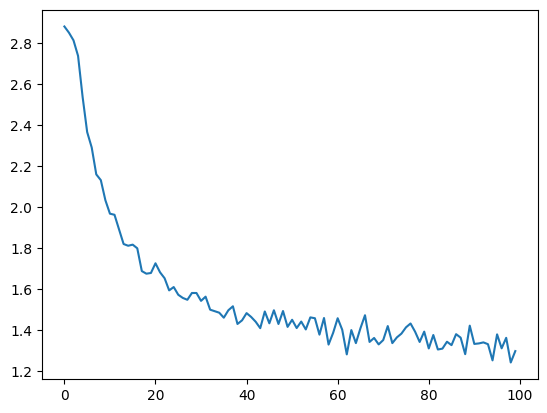

In [32]:
# Create a new empty figure to hold the plot
plt.figure()

# Plot the values from the 'all_losses' variable as a line plot
plt.plot(all_losses)

## Evaluating the Results

 **Confusion matrix will visualize network's performance across languages. Rows represent actual languages, columns represent network's guesses. Evaluate samples using `evaluate()` (similar to `train()` without backprop) to generate the matrix.**

In [33]:
# Create a Tensor to store the confusion matrix, initialized with zeros
confusion = torch.zeros(n_categories, n_categories)  # Each row/column represents a category

# Set the number of samples to use for calculating the confusion matrix
n_confusion = 10000

In [34]:
def evaluate(line_tensor: torch.Tensor) -> torch.Tensor:
    """Efficiently processes a line of text using an RNN and returns its final understanding.

    Args:
        line_tensor (torch.Tensor): A tensor of character codes representing the line.

    Returns:
        torch.Tensor: The RNN's final output capturing its understanding of the line.
    """

    hidden = rnn.initHidden()  # Initialize hidden state

    for char_tensor in line_tensor:  # Iterate through character tensors
        output, hidden = rnn(char_tensor, hidden)  # Process characters and update hidden state

    return output  # Return the RNN's final output

In [35]:
# Loop through a specified number of examples to populate the confusion matrix
for i in range(n_confusion):
    # Retrieve a random training example with its category and text
    category, line, category_tensor, line_tensor = random_training_example()

    # Evaluate the line using the RNN to get its prediction
    output = evaluate(line_tensor)

    # Determine the network's guessed category from the output
    guess, guess_i = category_from_output(output)

    # Get the numerical index of the actual category
    category_i = all_categories.index(category)

    # Update the confusion matrix based on the actual and guessed categories
    confusion[category_i][guess_i] += 1  # Increment count for this combination

In [36]:
# Normalize each row of the confusion matrix to represent proportions
for i in range(n_categories):
    # Divide each element in the row by the total count in that row
    confusion[i] = confusion[i] / confusion[i].sum()  # Values now represent percentages

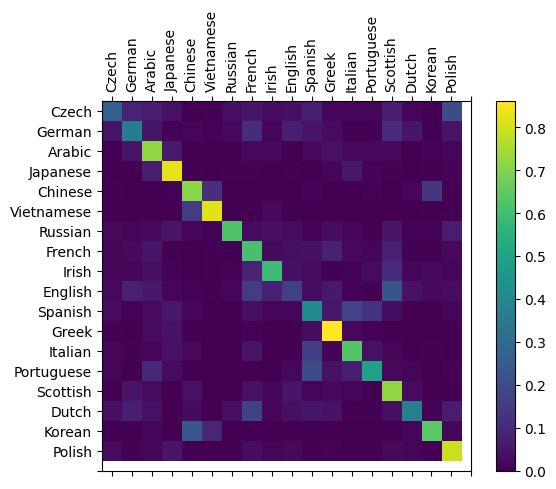

In [37]:
# Create the plot structure
fig, ax = plt.subplots()  # Create a new figure and a single subplot within it

# Visualize the confusion matrix
cax = ax.matshow(confusion.numpy())  # Display the confusion matrix as a color-coded heatmap
fig.colorbar(cax)  # Add a colorbar to the side to interpret the color values in the heatmap

# Configure the axes
ax.set_xticks(range(len(all_categories)+1))  # Set the x-axis tick positions to cover all categories + 1 extra
ax.set_yticks(range(len(all_categories)+1))  # Set the y-axis tick positions similarly

ax.set_xticklabels(all_categories + [''], rotation=90)  # Add category labels to x-axis ticks, rotated 90 degrees
ax.set_yticklabels(all_categories + [''])  # Add category labels to y-axis ticks

# Ensure a label for each category (not strictly necessary now, but can be kept for clarity)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))  # Force a tick mark at every integer position on x-axis
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))  # Force a tick mark at every integer position on y-axis

plt.show()  # Display the plot

The network's performance varies across different languages. We can observe areas where it excels, like Greek, and others where it faces challenges, such as English (potentially due to similarities with other languages).

### Running on User Input




In [38]:
def predict(input_line: str, n_predictions: int = 3) -> list[tuple[float, str]]:
    """Efficiently predicts language categories for an input line and returns top predictions.

    Args:
        input_line (str): The line of text to predict.
        n_predictions (int, optional): Number of top predictions to return. Defaults to 3.

    Returns:
        list[tuple[float, str]]: List of (prediction value, category) tuples.
    """

    print(f"\n> {input_line}")  # Display the input line

    with torch.no_grad():  # Temporarily disable gradients for efficiency
        output = evaluate(line_to_tensor(input_line))  # Evaluate using the model
        top_values, top_indices = output.topk(n_predictions, 1, True)  # Get top predictions

    predictions = [(value.item(), all_categories[index.item()])
                   for value, index in zip(top_values[0], top_indices[0])]  # Create prediction list

    for prediction_value, category in predictions:  # Print predictions
        print(f"({prediction_value:.2f}) {category}")

    return predictions  # Return the list of top predictions

In [39]:
# Predict the language of the name 'Dovesky' and print the top 3 predictions
predict('Dovesky')

# Predict the language of the name 'Jackson' and print the top 3 predictions
predict('Jackson')

# Predict the language of the name 'Satoshi' and print the top 3 predictions
predict('Satoshi')


> Dovesky
(-0.92) Czech
(-1.11) Russian
(-2.34) English

> Jackson
(-0.34) Scottish
(-1.98) English
(-3.54) German

> Satoshi
(-1.04) Japanese
(-1.12) Arabic
(-1.78) Greek


[(-1.0359770059585571, 'Japanese'),
 (-1.1195484399795532, 'Arabic'),
 (-1.7802320718765259, 'Greek')]

### Congratulations! You have completed the tutorial.